In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

Сначала загружаем данные

In [2]:
from sklearn.model_selection import train_test_split
x_data = np.load('data/x_train.npy')
y_data = np.load('data/y_train.npy')
print('Loaded data with %d samples' % len(x_data))

Loaded data with 15000 samples


In [3]:
df = pd.DataFrame(x_data)
target = pd.DataFrame(y_data)

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['date'][:1]

0   2014-09-16
Name: date, dtype: datetime64[ns]

C:\Users\NMikhaylov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


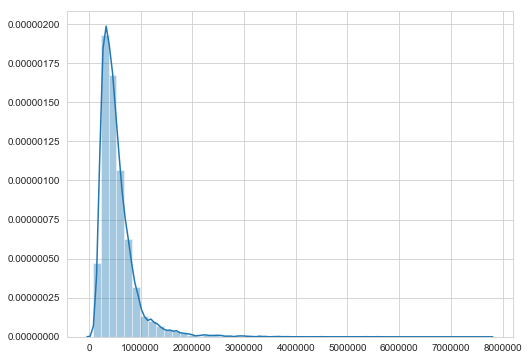

In [5]:
plt.figure(figsize=(8, 6))
y = target.values
sns.distplot(y)

Видим странное распределение, похожее на нормальное. Попробуем взять логарифм

C:\Users\NMikhaylov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


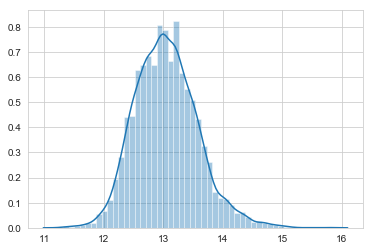

In [6]:
target_log = np.log(target)
y_log = target_log.values
sns.distplot(y_log)

Будем предсказывать логирифм цены, так как он менее тяжелый. 

Посмотрим на графики зависимости цены от каждого из признаков.

In [7]:
def pairplot(df, target):
    ncol, nrow = 4, df.shape[1] // 4 + (df.shape[1] % 4 > 0)
    plt.figure(figsize=(ncol * 4, nrow * 4))

    for i, feature in enumerate(df.columns):
        plt.subplot(nrow, ncol, i + 1)
        plt.scatter(df[feature].values, target.values, s=10, marker='o', alpha=.6)
        plt.xlabel(feature)
        if i % ncol == 0:
            plt.ylabel('target')

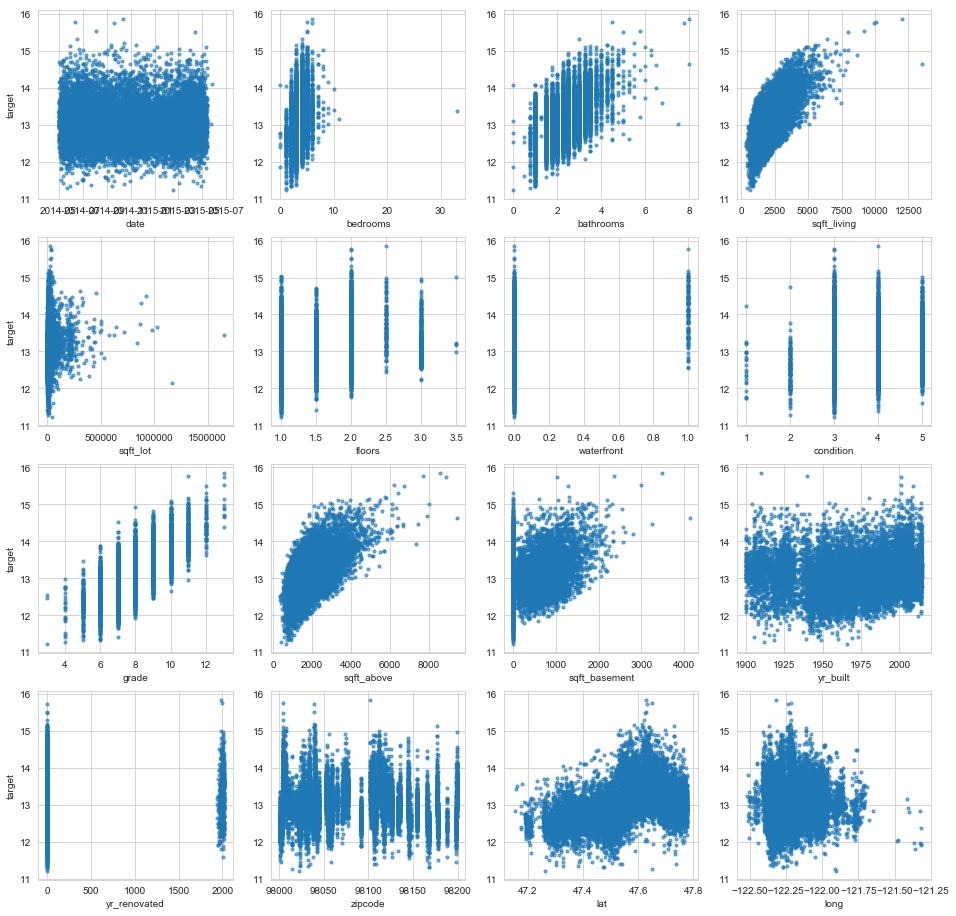

In [8]:
pairplot(df, target_log)

Выкинем год постройки и zip-код. Как видим ценна не особо от них зависит

С датой пока повременим. Возможно есть зависимость по месяцам

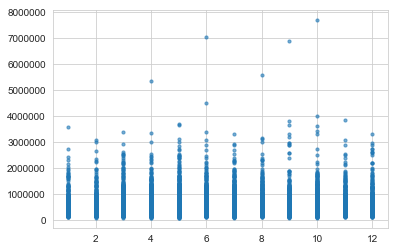

In [9]:
plt.scatter(df['date'].dt.month, target.values, s=10, marker='o', alpha=.6)

Не похоже

In [10]:
df = df.drop(columns=['date', 'zipcode', 'sqft_lot', 'yr_renovated'])
df['waterfront'] -= !df['waterfront']

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df, target_log, test_size=0.3, random_state=42)

In [42]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

In [13]:
alphas = np.logspace(-2, 2, 10)
degrees = list(range(1, 5))
def get_best_models(x_train, y_train):
    pipe = Pipeline(
            [('polynom', PolynomialFeatures()),
             ('scaler', StandardScaler()),
             ('regressor', Lasso())])
    search_params = [
        {
            'polynom': [PolynomialFeatures()],
            'polynom__degree' : degrees,
            'scaler': [StandardScaler(), MinMaxScaler()],
            'regressor':[Lasso(), Ridge()],
            'regressor__max_iter' : [2500],
            'regressor__alpha': alphas
        },
        {
            'polynom': [PolynomialFeatures()],
            'polynom__degree' : degrees,
            'scaler': [StandardScaler(), MinMaxScaler()],
            'regressor':[LogisticRegression(penalty='l1')],
            'regressor__max_iter' : [2500],
            'regressor__alpha': alphas
        }
        
    ]
    gs_cv = GridSearchCV(pipe, param_grid=search_params, refit=True, cv=5, return_train_score=True, verbose=1, scoring='neg_mean_absolute_error')
    gs_cv.fit(x_train, y_train)
    return gs_cv

In [14]:
model = get_best_models(x_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


C:\Users\NMikhaylov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\NMikhaylov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\NMikhaylov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 12.3min finished


In [15]:
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynom,param_polynom__degree,param_regressor,param_regressor__alpha,param_regressor__max_iter,param_scaler,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017196,2.936135e-03,0.000601,8.019924e-04,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.01,2500,"StandardScaler(copy=True, with_mean=True, with...",...,-0.203851,0.002979,72,-0.202587,-0.204103,-0.203251,-0.203197,-0.204606,-0.203549,0.000716
1,0.012501,6.250691e-03,0.003125,6.250954e-03,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.01,2500,"MinMaxScaler(copy=True, feature_range=(0, 1))",...,-0.247293,0.003206,93,-0.247460,-0.243817,-0.248038,-0.246481,-0.249971,-0.247153,0.002020
2,0.015627,2.780415e-07,0.000000,0.000000e+00,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.0278256,2500,"StandardScaler(copy=True, with_mean=True, with...",...,-0.211077,0.003176,82,-0.209848,-0.211811,-0.210512,-0.210274,-0.211952,-0.210879,0.000847
3,0.009263,6.532061e-03,0.003526,6.099414e-03,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.0278256,2500,"MinMaxScaler(copy=True, feature_range=(0, 1))",...,-0.318796,0.002553,99,-0.319096,-0.318822,-0.318888,-0.317719,-0.318740,-0.318653,0.000482
4,0.009377,7.656330e-03,0.006251,7.655590e-03,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.0774264,2500,"StandardScaler(copy=True, with_mean=True, with...",...,-0.239201,0.003202,88,-0.238607,-0.239568,-0.238811,-0.238647,-0.239687,-0.239064,0.000467
5,0.014589,1.010391e-03,0.001303,7.502845e-04,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.0774264,2500,"MinMaxScaler(copy=True, feature_range=(0, 1))",...,-0.416818,0.003503,105,-0.415816,-0.417676,-0.417797,-0.416987,-0.415762,-0.416808,0.000876
6,0.011347,5.733972e-03,0.004329,5.701634e-03,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.215443,2500,"StandardScaler(copy=True, with_mean=True, with...",...,-0.332424,0.005723,103,-0.332282,-0.332793,-0.332101,-0.331645,-0.332687,-0.332302,0.000415
7,0.012426,6.565908e-03,0.003526,6.099698e-03,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.215443,2500,"MinMaxScaler(copy=True, feature_range=(0, 1))",...,-0.416818,0.003503,105,-0.415816,-0.417676,-0.417797,-0.416987,-0.415762,-0.416808,0.000876
8,0.018752,1.531065e-02,0.003125,6.250477e-03,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.599484,2500,"StandardScaler(copy=True, with_mean=True, with...",...,-0.416818,0.003503,105,-0.415816,-0.417676,-0.417797,-0.416987,-0.415762,-0.416808,0.000876
9,0.016624,2.794962e-03,0.000401,8.018494e-04,"PolynomialFeatures(degree=2, include_bias=True...",1,"Lasso(alpha=100.0, copy_X=True, fit_intercept=...",0.599484,2500,"MinMaxScaler(copy=True, feature_range=(0, 1))",...,-0.416818,0.003503,105,-0.415816,-0.417676,-0.417797,-0.416987,-0.415762,-0.416808,0.000876


In [16]:
best_model = model.best_estimator_

In [17]:
import sklearn.metrics

In [24]:
sklearn.metrics.mean_absolute_error(y_pred=np.exp(best_model.predict(x_test)), y_true=np.exp(y_test))

103612.40978821632

In [25]:
pd.DataFrame(model.cv_results_).loc[model.best_index_, :]

mean_fit_time                                                        0.0406285
std_fit_time                                                        0.00765477
mean_score_time                                                     0.00625024
std_score_time                                                      0.00765495
param_polynom                PolynomialFeatures(degree=2, include_bias=True...
param_polynom__degree                                                        2
param_regressor              Ridge(alpha=0.01, copy_X=True, fit_intercept=T...
param_regressor__alpha                                                    0.01
param_regressor__max_iter                                                 2500
param_scaler                 StandardScaler(copy=True, with_mean=True, with...
params                       {'polynom': PolynomialFeatures(degree=2, inclu...
split0_test_score                                                    -0.193138
split1_test_score                                   

In [28]:
x_valid = pd.DataFrame(np.load('data/x_test.npy')).drop(columns=['date', 'zipcode', 'sqft_lot', 'yr_renovated'])
y_pred = np.exp(best_model.predict(x_valid))

In [30]:
target_pred = pd.DataFrame(y_pred)

In [40]:
target_pred.columns = ['Price']
target_pred.index.name = 'Id'
target_pred.index += 1

In [41]:
target_pred.to_csv('pred.csv')